# Loading the dataset from Kaggle

In [ ]:
from google.colab import files

# Upload kaggle.json downloaded from Kaggle account
files.upload()

In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d xhlulu/recursion-cellular-image-classification-224-jpg

In [ ]:
!unzip recursion-cellular-image-classification-224-jpg.zip

# Import required libraries

In [13]:
import pandas as pd
import pandas as pd
import os
import numpy as np
import random
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
import tensorflow as tf


# Loading train data




In [2]:


train_csv_path = "new_train.csv"
train_df = pd.read_csv(train_csv_path)

# Number of images
num_images = len(train_df)
print("Number of images:", num_images)

# Number of unique sirna classes
num_classes = train_df['sirna'].nunique()
print("Number of sirna classes:", num_classes)
train_df.head()

Number of images: 73030
Number of sirna classes: 1108


,id_code,experiment,plate,well,sirna,filename
0,HEPG2-01_1_B03,HEPG2-01,1,B03,513,HEPG2-01_1_B03_s1.jpeg
1,HEPG2-01_1_B04,HEPG2-01,1,B04,840,HEPG2-01_1_B04_s1.jpeg
2,HEPG2-01_1_B05,HEPG2-01,1,B05,1020,HEPG2-01_1_B05_s1.jpeg
3,HEPG2-01_1_B06,HEPG2-01,1,B06,254,HEPG2-01_1_B06_s1.jpeg
4,HEPG2-01_1_B07,HEPG2-01,1,B07,144,HEPG2-01_1_B07_s1.jpeg


In [3]:

num_rows_to_drop = 50000

# Randomly select rows to drop
rows_to_drop = train_df.sample(n=num_rows_to_drop).index

# Drop the selected rows
train_df = train_df.drop(rows_to_drop)

In [4]:
num_images = len(train_df)
print("Number of images:", num_images)

num_classes = train_df['sirna'].nunique()
print("Number of sirna classes:", num_classes)

Number of images: 23030
Number of sirna classes: 1108


In [5]:
NB_CLASSES = 1108

In [6]:

from PIL import Image

# Step 2: Loading Image Data and Creating Labels (x_train and y_train)
train_images_dir = "./train/train"  # Directory containing train images
x_train = []
y_train = []

for _, row in train_df.iterrows():
    image_filename = row['filename']
    image_path = os.path.join(train_images_dir, image_filename)

    # Load image
    image = Image.open(image_path)


    # Convert image to numpy array and append to x_train
    # image = np.array(image) / 255.0
    x_train.append(np.array(image))

    # Append corresponding sirna value to y_train
    y_train.append(row['sirna'])

# Convert lists to numpy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

# Display shapes of loaded image arrays
print("Shape of x_train:", x_train.shape)
print("Shape of y_train:", y_train.shape)

Shape of x_train: (23030, 224, 224, 3)
Shape of y_train: (23030,)


In [7]:
IMG_WIDTH = 224
IMG_HEIGHT = 224

In [8]:
y_train = y_train.reshape(len(y_train), 1)
print("Shape of y_train:", y_train.shape)

Shape of y_train: (23030, 1)


[[[[236 132 185]
   [238 141 192]
   [226 144 190]
   ...
   [234 222 236]
   [253 247 255]
   [255 252 255]]

  [[237 131 180]
   [228 130 177]
   [212 131 172]
   ...
   [248 236 250]
   [253 246 255]
   [252 248 255]]

  [[231 124 166]
   [213 115 154]
   [196 112 148]
   ...
   [255 248 255]
   [255 251 255]
   [247 244 255]]

  ...

  [[255 222 255]
   [255 223 255]
   [255 207 255]
   ...
   [252 156 245]
   [255 164 255]
   [255 174 255]]

  [[233 199 249]
   [251 215 255]
   [255 217 255]
   ...
   [249 149 239]
   [252 150 249]
   [249 147 247]]

  [[209 177 226]
   [237 204 249]
   [253 219 255]
   ...
   [221 118 209]
   [243 137 237]
   [251 143 245]]]]


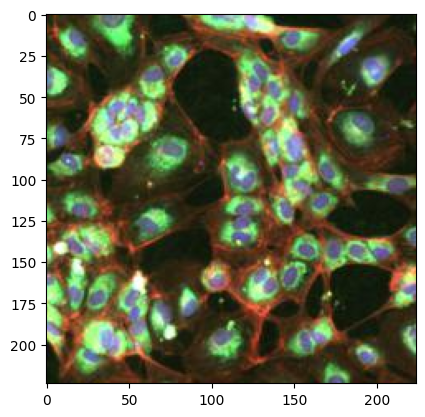

In [9]:
# example
print(x_train[:1])
idx = random.randint(0, len(x_train))
plt.imshow(x_train[idx, :])
plt.show()

In [10]:
# Rescale images in batches
batch_size = 10000
new_x_train = []
for i in range(0, len(x_train), batch_size):
    start_index = i
    end_index = min(i + batch_size, len(x_train))
    print(f"Rescaling images from index {start_index} to {end_index}")
    for j in range(start_index, end_index):
      new_x_train.append(x_train[j] /255.0)

Rescaling images from index 0 to 10000
Rescaling images from index 10000 to 20000
Rescaling images from index 20000 to 23030


In [ ]:
new_x_train = np.array(new_x_train)
new_x_train.shape()
x_train = new_x_train

# Splitting data into training and validation data

In [11]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Display the shapes of the resulting arrays
print("Shape of x_train:", x_train.shape)
print("Shape of x_val:", x_val.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_val:", y_val.shape)

Shape of x_train: (18424, 224, 224, 3)
Shape of x_val: (4606, 224, 224, 3)
Shape of y_train: (18424, 1)
Shape of y_val: (4606, 1)



# model 1




In [ ]:
model = Sequential([
    Conv2D(filters=128, kernel_size=(5, 5), padding='valid', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    Conv2D(filters=64, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    Conv2D(filters=32, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    Flatten(),

    Dense(units=3500, activation='relu'),
    Dropout(0.5),
    Dense(units=NB_CLASSES, activation='softmax')
])


plot model

In [ ]:
import tensorflow as tf

tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
)

# model 2

In [30]:
model = Sequential([
    Conv2D(32, (3,3), activation = 'relu', input_shape = (224, 224, 3)),
    MaxPooling2D((2,2)),

    Conv2D(32, (3,3), activation = 'relu'),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(2000, activation = 'relu'),
    Dense(1108, activation = 'softmax')
])

In [31]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)

In [32]:
optimizer = Adam(learning_rate=0.001)

In [42]:
#model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(x_train, y_train, epochs = 10, batch_size = 128, verbose=2, callbacks=[reduce_lr])

In [ ]:
model.evaluate(x_val, y_val)

# model 3

In [ ]:
# Define CNN model
model = Sequential([
    Conv2D(128, (3, 3), activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(3000, activation='relu'),
    Dropout(0.5),
    Dense(NB_CLASSES, activation='softmax')
])

import tensorflow as tf

tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
)

# Compile the model
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train, epochs=8, batch_size=64, validation_data=(x_val, y_val))

# Evaluate the model
loss, accuracy = model.evaluate(x_val, y_val)
print('Validation loss:', loss)
print('Validation accuracy:', accuracy)

# model 4

In [13]:
from keras.preprocessing.image import ImageDataGenerator




# Define data generators with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1.0/255)

# Define batch size
batch_size = 32

# Create data generators
train_generator = train_datagen.flow(x_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(x_val, y_val, batch_size=batch_size)


In [14]:
# Define CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(NB_CLASSES, activation='softmax')
])


In [ ]:
# Compile the model
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [16]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(x_train) // batch_size,
    epochs=5,
    validation_data=val_generator,
    validation_steps=len(x_val) // batch_size
)


Epoch 1/5
575/575 [==============================] - 466s 808ms/step - loss: 11595768484897751040.0000 - accuracy: 0.0000e+00 - val_loss: 16470510665728.0000 - val_accuracy: 0.0000e+00
Epoch 2/5
575/575 [==============================] - 480s 835ms/step - loss: 35084539265024.0000 - accuracy: 0.0000e+00 - val_loss: 27388217917440.0000 - val_accuracy: 0.0000e+00
Epoch 3/5
575/575 [==============================] - 449s 780ms/step - loss: 49520343777280.0000 - accuracy: 0.0000e+00 - val_loss: 35861441806336.0000 - val_accuracy: 0.0000e+00
Epoch 4/5
575/575 [==============================] - 490s 852ms/step - loss: 62466390228992.0000 - accuracy: 5.4371e-05 - val_loss: 43879814397952.0000 - val_accuracy: 0.0000e+00
Epoch 5/5
575/575 [==============================] - 486s 845ms/step - loss: 74962085871616.0000 - accuracy: 0.0000e+00 - val_loss: 51850178985984.0000 - val_accuracy: 0.0000e+00


In [17]:
# Evaluate the model
loss, accuracy = model.evaluate(val_generator)
print('Validation loss:', loss)
print('Validation accuracy:', accuracy)

144/144 [==============================] - 29s 202ms/step - loss: 51862170501120.0000 - accuracy: 0.0000e+00
Validation loss: 51862170501120.0
Validation accuracy: 0.0


# Final model

In [17]:
tm = tf.keras.Sequential(
    [

# Convolution (Convolution layers + Activation function)
# purpose : to Keep the most important features in an image
# result : feature map/activation map

    tf.keras.layers.Conv2D(32, (4,4), activation="relu",input_shape=(224, 224, 3)),

# Pooling (Pooling Layer)
# purpose : to ensures that the main features of the image are maintained while reducing the size of the image further (spatial invariance)
# result : pooled feature map
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),


# Convolution (Convolution layers + Activation function)
    tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
# Pooling (Pooling Layer)
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),

# Flattening
# result : transforming the pooled feature map into one column
    tf.keras.layers.Flatten(),
# Full connection (Fully Connected Layer / Dense layer)
    tf.keras.layers.Dense(1108, activation="relu"),
# Dropout Layer :
# purpose : to reduce overfitting
    tf.keras.layers.Dropout(rate=0.3),

# Full connection (Fully Connected Layer / Dense layer)
    tf.keras.layers.Dense(1108, activation='softmax')
]
)

tm.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 221, 221, 32)      1568      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 110, 110, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 108, 108, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 186624)            0         
                                                                 
 dense_2 (Dense)             (None, 1108)             

Plot the model

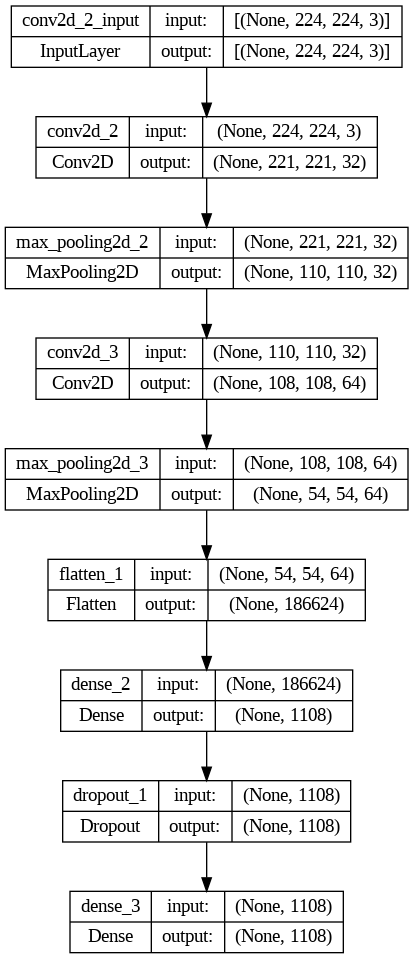

In [20]:

tf.keras.utils.plot_model(
    tm,
    to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
)

In [18]:
tm.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:

historyTm = tm.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val))

In [ ]:
# Evaluate the model
loss, accuracy = tm.evaluate(x_val, y_val)
print('Validation loss:', loss)
print('Validation accuracy:', accuracy)